In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline

In [2]:
from skimage.feature import hog

In [3]:
from sklearn.externals import joblib
normalizer = joblib.load('normalizer.pkl') 
clf = joblib.load('model.pkl') 

In [4]:
image = mpimg.imread('test_images/test4.jpg')

# 1. get Sliding Window Position

In [5]:
"""
lecture 32. Sliding Window Implementation
"""
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # get window position
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            window_list.append(((startx, starty), (endx, endy)))
    return window_list

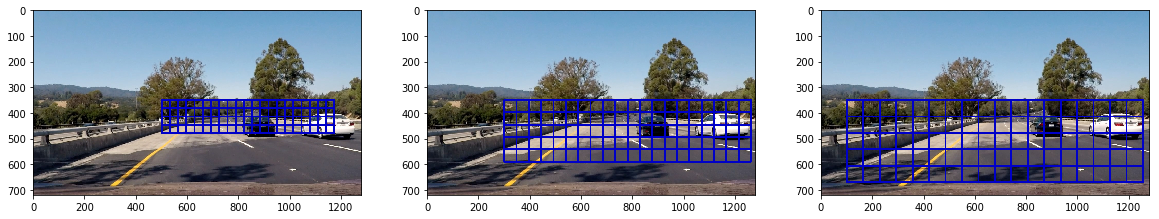

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,6))

windows1 = slide_window(image, x_start_stop=[500, 1200], y_start_stop=[350, 500], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)) 
windows2 = slide_window(image, x_start_stop=[300, 1300], y_start_stop=[350, 600], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5)) 
windows3 = slide_window(image, x_start_stop=[100, None], y_start_stop=[350, 700], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)) 


window_img = draw_boxes(image, windows1, color=(0, 0, 200), thick=6)                    
ax1.imshow(window_img)

window_img = draw_boxes(image, windows2, color=(0, 0, 200), thick=6)                    
ax2.imshow(window_img)

window_img = draw_boxes(image, windows3, color=(0, 0, 200), thick=6)                    
ax3.imshow(window_img)

# 2. define the same functions as ones in 1_TrainClassifier.ipynb

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256), visualize=False):
    """color histgram features"""
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    if visualize == True: 
        return rhist, ghist, bhist, bin_centers, hist_features
    else:
        return hist_features

In [8]:
def bin_spatial(img, size=(32, 32)):
    """color features"""
    features = cv2.resize(img, size).ravel() 
    return features

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# 3. define vehicle detection function

In [10]:
"""
Lecture 34. Search and Classify
"""
def single_img_features(img, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2):    
    img_features = []
    
    feature_image = img
    # color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    img_features.append(spatial_features)
    
    hist_features = color_hist(feature_image, nbins=hist_bins)
    img_features.append(hist_features)

    # convert color space
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # HOG features
    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))      
    img_features.append(hog_features)

    return np.concatenate(img_features)

In [11]:
"""
Lecture 34. Search and Classify
"""
def search_windows(img, windows, clf, scaler, 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2):
    """
    in: image, all windows
    out: vehicle detected windows
    """
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# 4. define pipeline

In [12]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

spatial_size = (32, 32)
hist_bins = 32

In [13]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

In [14]:
def pipeline(image):
    image = image.astype(np.float32)/255
    image_org = np.copy(image)
    
    windows1 = slide_window(image, x_start_stop=[500, 1200], y_start_stop=[350, 500], 
                        xy_window=(64, 64), xy_overlap=(0.9, 0.9)) 
    windows2 = slide_window(image, x_start_stop=[300, 1300], y_start_stop=[350, 600], 
                        xy_window=(96, 96), xy_overlap=(0.9, 0.9)) 
    windows3 = slide_window(image, x_start_stop=[100, None], y_start_stop=[350, 700], 
                        xy_window=(128, 128), xy_overlap=(0.9, 0.9)) 
    
    windows = windows1+windows2+windows3
    
    hot_windows = search_windows(image, windows, clf, normalizer, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)                       

    window_img = draw_boxes(image, hot_windows, color=(1, 0, 1), thick=6)                    

    return window_img

/Users/riki/.pyenv/versions/anaconda3-4.1.1/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


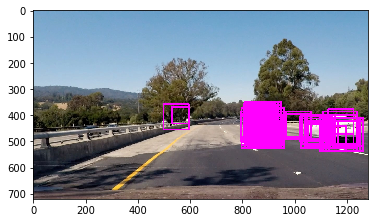

In [15]:
result = pipeline(image)
plt.imshow(result)

---

## ToDo

* combine window w/ heat map
  * drop false-positive
  * combine multiple windows
  
* speed up window search w/ sub-sampling feature map